In [1]:
import os
import pandas as pd
import numpy as np
from pyecg import ECGRecord
import biosignalsnotebooks as bsnb
from numpy import linspace, diff, zeros_like, arange, array
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

path = "./database/ecgdata/"
file = "S0250ECG.hea"
lead = "ecg_0"
sr = 1000 #Sampling frequency

#Data extraction from patient S0250.
hea_path = path + file #Change the location of the file or folder.
record = ECGRecord.from_wfdb(hea_path)
#time = record.time
signal = record.get_lead(lead)
time = bsnb.generate_time(signal)
signal_amplified = []

#Selecting a set of data of choice and storing it inside another array.
n = 200000
while n < 203000:
    signal_amplified.append(signal[n])
    n += 1

#Step 1 of Pan-Tompkins Algorithm
filtered_signal = bsnb.detect._ecg_band_pass_filter(signal_amplified, sr)

#Step 2 of Pan-Tompkins Algorithm
differentiated_signal = diff(filtered_signal)

#Step 3 of Pan-Tompkins Algorithm
squared_signal = differentiated_signal * differentiated_signal

#Step 4 Moving Window Integration
nbr_sampls_int_wind = int(0.080 * sr)
integrated_signal = zeros_like(squared_signal)
cumulative_sum = squared_signal.cumsum()
integrated_signal[nbr_sampls_int_wind:] = (cumulative_sum[nbr_sampls_int_wind:] - cumulative_sum[:-nbr_sampls_int_wind]) / nbr_sampls_int_wind
integrated_signal[:nbr_sampls_int_wind] = cumulative_sum[:nbr_sampls_int_wind] / arange(1, nbr_sampls_int_wind + 1)

#Step 5 Detecting the R-peaks
rr_buffer, signal_peak_1, noise_peak_1, threshold = bsnb.detect._buffer_ini(integrated_signal, sr)
probable_peaks, possible_peaks= bsnb.detect._detects_peaks(integrated_signal, sr)
definitive_peaks = bsnb.detect._checkup(probable_peaks, integrated_signal, sr, rr_buffer, signal_peak_1, noise_peak_1, threshold)
# Conversion to integer type.
definitive_peaks = array(list(map(int, definitive_peaks)))
map_integers = definitive_peaks - 40 * (sr / 1000)
definitive_peaks_reph = array(list(map(int, map_integers)))


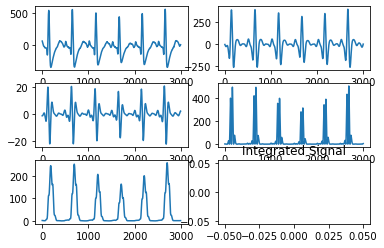

In [14]:
%matplotlib inline
figure, axes = plt.subplots(nrows=3, ncols=2)

axes[0, 0].plot(signal_amplified)
plt.title("Unfiltered Signal")
plt.axis("tight")
plt.rcParams["figure.figsize"] = (200,3)

axes[0, 1].plot(filtered_signal)
plt.title("Filtered signal")
plt.axis("tight")
plt.rcParams["figure.figsize"] = (200,3)

axes[1, 0].plot(differentiated_signal)
plt.title("Differentiated signal")
plt.axis("tight")
plt.rcParams["figure.figsize"] = (200,3)

axes[1, 1].plot(squared_signal)
plt.title("Squared Signal")
plt.axis("tight")
plt.rcParams["figure.figsize"] = (200,3)

curve, = axes[2, 0].plot(integrated_signal)
plt.title("Integrated Signal")
plt.axis("tight")
plt.rcParams["figure.figsize"] = (200,3)
x_data = curve.get_xdata()

plt.show()

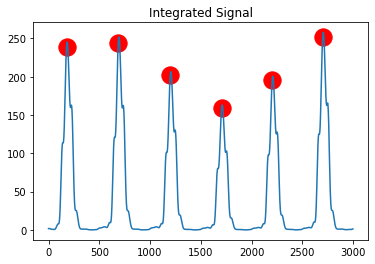

In [12]:
%matplotlib inline
#Final step Plotting the R-intervals on the signal
y_values = []
for definitive in definitive_peaks:
    value = np.interp(definitive, x_data, integrated_signal)
    y_values.append(value)

plt.plot(integrated_signal)
plt.title("Integrated Signal")
plt.axis("tight")
plt.scatter(definitive_peaks,y_values, s=300, c='red')

    

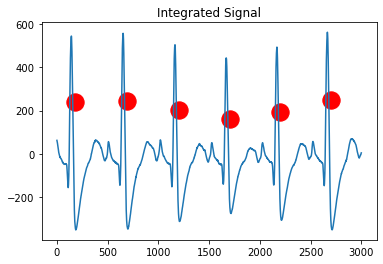

In [13]:
%matplotlib inline
plt.plot(signal_amplified)
plt.title("Integrated Signal")
plt.axis("tight")
plt.scatter(definitive_peaks,y_values, s=300, c='red')